## Land Use Classification | Exploratory Data Analysis

Before building the deep learning model, it's worth it to get more familiar with the dataset. Especially as an image dataset, visualizations help us see differences in the different image categories as well as the red, green, and blue bands of a single image.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import rasterio
from rasterio.plot import show, show_hist
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style="white")

In [3]:
path = "dataset/"

In [4]:
# get names of label folders
categories = []
for (dirpath, dirnames, filenames) in os.walk(path + 'land-use-tif/'):
    categories.extend(dirnames)

In [5]:
total = 0
len_categories = {}
for category in categories:
    len_files = len(os.listdir(path + 'land-use-tif/' + category + '/'))
    total += len_files
    len_categories[category] = len_files

### Photos by Category

The bar chart shows the number of photos in each category in the dataset, which range from about 2500 photos in the Industrial and River categories to about 6000 in the AnnualCrop, SeaLake, HerbaceousVegetation, and Residential Categories. Imbalances in  representation could affect the efficacy of the model, but we will leave the dataset as is for now.

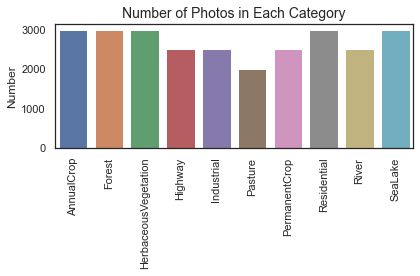

In [6]:
x = list(range(len(len_categories)))
y = list(len_categories.values())
ax = sns.barplot(x, y)
plt.title("Number of Photos in Each Category", fontsize=14)
plt.ylabel("Number")
plt.xticks(x, list(len_categories.keys()), rotation=90)
plt.tight_layout()
plt.show()

In [7]:
images = [path + 'land-use-jpeg/train/AnnualCrop/AnnualCrop_1.jpg',
         path + 'land-use-jpeg/train/Forest/Forest_1.jpg',
         path + 'land-use-jpeg/train/HerbaceousVegetation/HerbaceousVegetation_1.jpg',
         path + 'land-use-jpeg/train/Highway/Highway_1.jpg',
         path + 'land-use-jpeg/train/Industrial/Industrial_1.jpg',
         path + 'land-use-jpeg/train/Pasture/Pasture_1.jpg',
         path + 'land-use-jpeg/train/PermanentCrop/PermanentCrop_1.jpg',
         path + 'land-use-jpeg/train/Residential/Residential_1.jpg',
         path + 'land-use-jpeg/train/River/River_1.jpg',
         path + 'land-use-jpeg/train/SeaLake/SeaLake_1.jpg']


The RGB representation of a photo from each category provides a better sense of what the images actually look like. Though they are relatively low quality, it's still pretty easy to see the difference between what is denoted as cropland, residential, highway, etc.

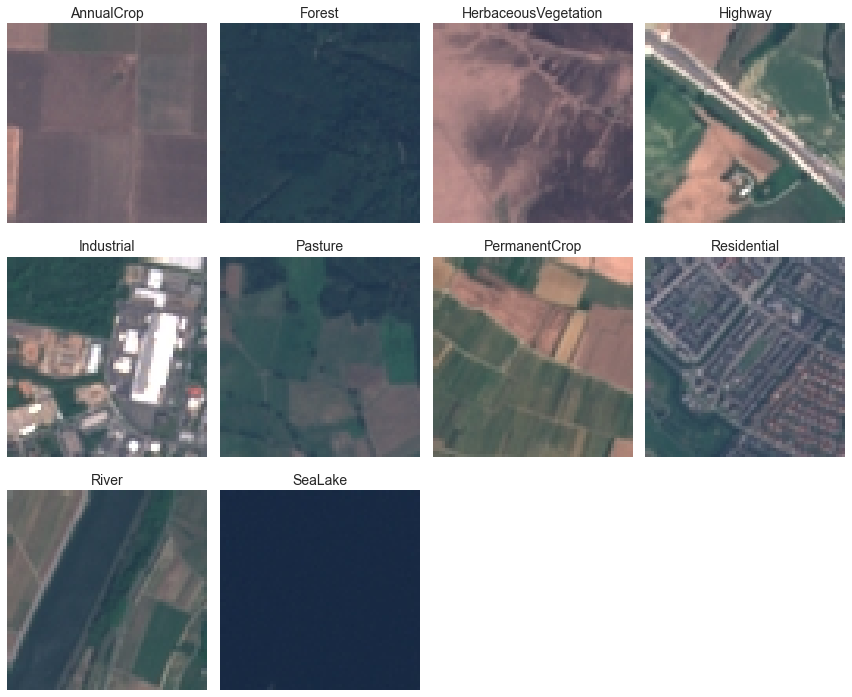

In [8]:
plt.figure(figsize=(12,10))
for i, img in enumerate(images, start=1):
    category = img.split('/')[3]
    plt.subplot(3, 4, i)
    data = plt.imread(img)
    plt.imshow(data)
    plt.axis('off')
    plt.title(category, fontsize=14)
plt.tight_layout()
plt.show()

### Photos by Color Band

The three color bands within each photo can also provide more information about the satellite data. The package `rasterio`, has helpful tools to extract information about the images that will be useful when constructing the convolutional neural network.

For example, the height and width of the images is 64 pixels, and there are 3 bands in each image. This makes sense, since we extracted three bands in our translation of the images from tif to jpeg. The RGB bands can be corroborated by the realistic look of the sample images from each category.

In [9]:
fp = path + 'land-use-jpeg/train/River/River_1.jpg'
raster = rasterio.open(fp)

print('Height:', raster.height)
print('Width:', raster.width)
print('Number of bands:', raster.count)

Height: 64
Width: 64
Number of bands: 3


Plotting each band doesn't tell us too much about the makeup of the data, but it is proof that there are three different bands in each image. 

Text(0.5, 1.0, 'Blue')

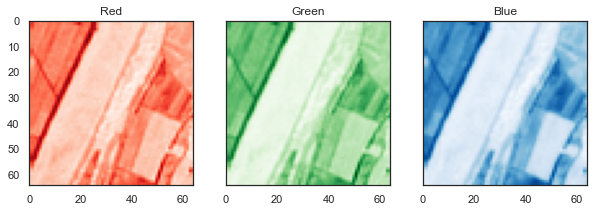

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(10, 4), sharey=True)

# Plot Red, Green and Blue (rgb)
show((raster, 3), cmap='Reds', ax=ax1)
show((raster, 2), cmap='Greens', ax=ax2)
show((raster, 1), cmap='Blues', ax=ax3)

# Add titles
ax1.set_title("Red")
ax2.set_title("Green")
ax3.set_title("Blue")

Stacking the three bands results in a RGB composite photo with realistic looking colors. In order to create this stack image, the bands have to be normalized first.

In [11]:
# from https://automating-gis-processes.github.io/CSC/notebooks/L5/plotting-raster.html

red = raster.read(1)
green = raster.read(2)
blue = raster.read(3)

# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

print("Normalized bands")
print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())

Normalized bands
0.0 - 1.0 mean: 0.35778478673986486
0.0 - 1.0 mean: 0.32833180147058827
0.0 - 1.0 mean: 0.3183527766047297


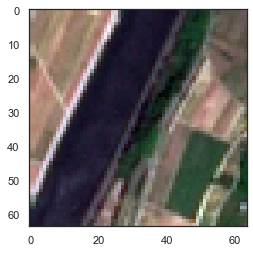

In [12]:
# Create RGB natural color composite
rgb = np.dstack((redn, greenn, bluen))

# Let's see how our color composite looks like
plt.imshow(rgb)

Plotting the wave frequencies of each band shows that there are differences in the pixel representation for each one. These differences could come in handy as the neural network learns the differences between image features in each category.

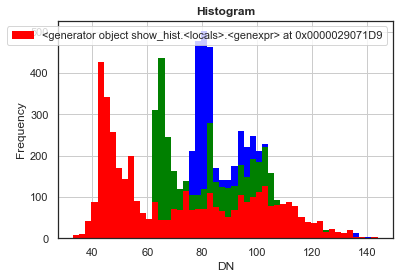

In [13]:
# see how the wavelengths of different bands are distributed
show_hist(raster, bins=50, lw=0.0, stacked=False,
      histtype='stepfilled', title="Histogram")